In [2]:
import warnings
warnings.filterwarnings('ignore')

import time
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    multilabel_confusion_matrix,
    accuracy_score,
    f1_score, 
    precision_score, 
    recall_score
)
from sklearn.utils import shuffle

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from tpot import TPOTClassifier

from fedot.api.main import Fedot

import mlflow
from mlflow.models import infer_signature

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [3]:
import os

## Пункт 1

In [4]:
n = 100_000
s = 10_000
skip = sorted(random.sample(range(n), n - s))
data = pd.read_csv('ecg_dataset.csv')
train_size = int(0.8 * len(data))

In [5]:
df_mitbih_train = data[:train_size]
df_mitbih_test = data[train_size:]
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)

In [6]:
# Датасет размечен на 5 классов, в исходном датасете столбец №187 содержит номер класса
df_mitbih.rename(columns={'label': 'class'}, inplace=True)

df_mitbih_test.rename(columns={'label': 'class'}, inplace=True)
df_mitbih_train.rename(columns={'label': 'class'}, inplace=True)

In [7]:
id_to_label = {
    0: 'Normal',     # Нормальный
    1: 'Artial Premature', # Преждевременное сокращение сердца (экстрасистолия)
    2: 'Premature ventricular contraction', # Преждевременное сокращение желудочков
    3: 'Fusion of ventricular and normal',  # Cлияние желудочкового и нормального сердечного ритма
    4: 'Fusion of paced and normal' # Cлияние стимулированного и нормального ритма
}

df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
df_mitbih_test['label'] = df_mitbih_test.iloc[:, -1].map(id_to_label)
df_mitbih_train['label'] = df_mitbih_train.iloc[:, -1].map(id_to_label)

print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100038 entries, 0 to 100037
Columns: 189 entries, 0 to label
dtypes: float64(187), int64(1), object(1)
memory usage: 144.3+ MB
None


In [8]:
df_mitbih_test = shuffle(df_mitbih_test)
df_mitbih_train = shuffle(df_mitbih_train)

df_mitbih_test = df_mitbih_test.reset_index(drop='True')
df_mitbih_train = df_mitbih_train.reset_index(drop='True')

In [9]:
rus_method = RandomUnderSampler()

df = df_mitbih_train
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df = pd.concat([X_resampled, y_resampled], axis=1)
new_df = new_df.dropna()

df = df_mitbih_test
df.columns = df.columns.astype(str)
X_resampled, y_resampled = rus_method.fit_resample(df.loc[:, df.columns != 'class'], df['class'])

new_df_test = pd.concat([X_resampled, y_resampled], axis=1)
new_df_test = new_df.dropna()

new_df['class'].value_counts()

0    873
1    873
2    873
Name: class, dtype: int64

2025-05-26 00:46:29,688 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 00:46:29,690 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


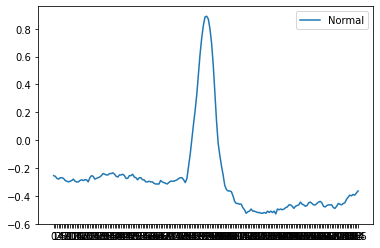

In [10]:
plt.plot(df_mitbih_train.iloc[0][:-3], label=str(df_mitbih_train.iloc[0]['label']))
plt.legend()
plt.show()

In [11]:
df_mitbih_train['label'] == 'Artial Premature'

0        False
1        False
2        False
3        False
4        False
         ...  
80025    False
80026    False
80027    False
80028    False
80029    False
Name: label, Length: 80030, dtype: bool

2025-05-26 00:46:34,040 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 00:46:34,044 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 00:46:34,047 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 00:46:34,048 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 00:46:34,050 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

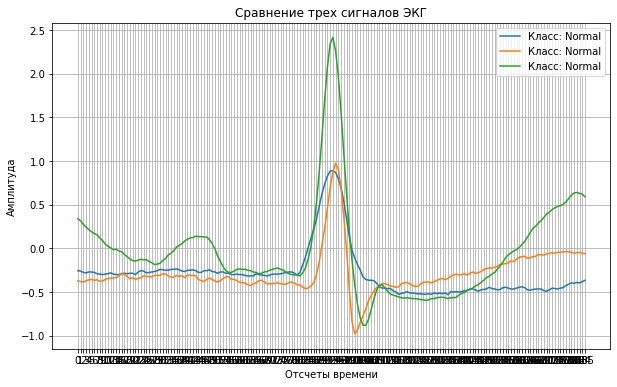

In [12]:
plt.figure(figsize=(10, 6))  # Задаем размер графика (опционально)

# Рисуем три сигнала с разными метками
plt.plot(df_mitbih_train.iloc[0][:-3], label=f"Класс: {df_mitbih_train.iloc[0]['label']}")
plt.plot(df_mitbih_train.iloc[1][:-3], label=f"Класс: {df_mitbih_train.iloc[80027]['label']}")
plt.plot(df_mitbih_train.iloc[2][:-3], label=f"Класс: {df_mitbih_train.iloc[2]['label']}")

plt.title("Сравнение трех сигналов ЭКГ")  # Заголовок
plt.xlabel("Отсчеты времени")            # Подпись оси X
plt.ylabel("Амплитуда")                  # Подпись оси Y
plt.legend()                             # Показываем легенду
plt.grid(True)                           # Включаем сетку (опционально)
plt.show()

## Пункт 2

In [13]:
class ECGDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        if 'label' in self.df.columns:
            self.df = self.df.drop('label', axis=1)
        
        if 'class' not in self.df.columns:
            raise ValueError("DataFrame должен содержать колонку 'class'")
            
        self.data_columns = [col for col in self.df.columns if col != 'class']
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        signal = row[self.data_columns].values.astype('float32')
        signal = torch.FloatTensor(signal).unsqueeze(0)  # [1, 187]
        
        # Получаем целевой класс как скаляр
        target = int(row['class'])  # Явное преобразование в int
        return signal, torch.tensor(target, dtype=torch.long)  # 0D тензор

In [14]:
def get_dataloader(df, phase: str, batch_size: int = 96):
    train_df, val_df = train_test_split(df, test_size=0.15, random_state=123, stratify=df['label'])
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    df = train_df if phase == 'train' else val_df
    
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    
    # Добавляем проверку коллации
    def collate_fn(batch):
        data = [item[0] for item in batch]
        targets = [item[1] for item in batch]
        return torch.stack(data), torch.stack(targets)
    
    dataloader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        num_workers=0,
        collate_fn=collate_fn
    )
    
    return dataloader
    
    return dataloader

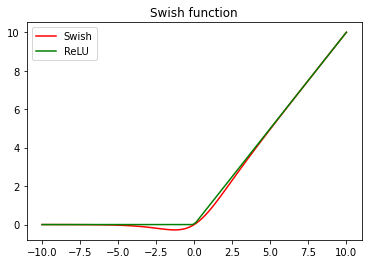

In [15]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), color='red', label='Swish')  # Красный для Swish
plt.plot(x.numpy(), relu_out.numpy(), color='green', label='ReLU')  # Зелёный для ReLU
plt.legend()
plt.show()

In [16]:
class RNN(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p=0.2,
        bidirectional=False,
    ):
        super().__init__()
        self.rnn_layer = nn.LSTM(
            input_size=input_size,
            hidden_size=hid_size,
            num_layers=num_rnn_layers,
            dropout=dropout_p if num_rnn_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True,
        )
    
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [17]:
class ConvNormPool(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [18]:
class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

In [29]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion
     

In [20]:
class Trainer:
    def __init__(self, df, net, lr, batch_size, num_epochs):
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(df, phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
        
    def _train_epoch(self, phase, net):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        net.train() if phase == 'train' else net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            meter.update(output, target, loss.item())
            
        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        print(
            '{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'.format(*(x for kv in metrics.items() for x in kv))
        )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss
    
    def run(self, net):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train',net=net)
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val',net=net)
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                os.makedirs("./models", exist_ok=True)
                torch.save(net.state_dict(), f"./models/best_model_epoc{epoch}.pth")

In [30]:
model = RNNAttentionModel(1, 64, bidirectional=False)


In [24]:
torch.save(model.state_dict(), 'rnn_attention_model.pth')

## Пункт 3

train mode | time: 00:52:15
loss: 1.3318938323621, accuracy: 0.5770786516853936, f1: 0.47985999643303046, precision: 0.627740324594257, recall: 0.6812078651685398


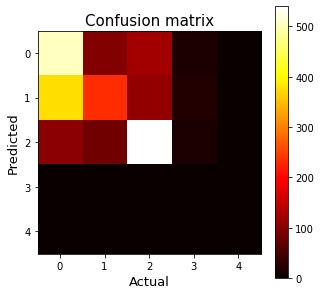

val mode | time: 00:52:22
loss: 1.2457019251126509, accuracy: 0.6846153846153845, f1: 0.5959147334147336, precision: 0.724358974358974, recall: 0.7810541310541308


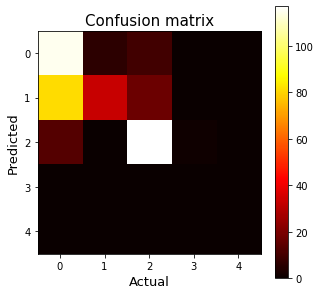


New checkpoint

train mode | time: 00:52:23
loss: 1.2248764172028959, accuracy: 0.6849438202247212, f1: 0.5936668450151593, precision: 0.7125905118601732, recall: 0.7609612983770291


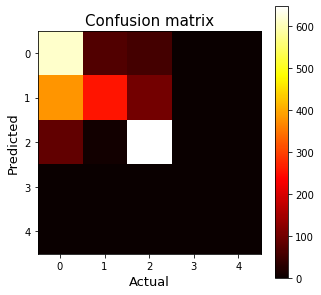

val mode | time: 00:52:29
loss: 1.213978308897752, accuracy: 0.7128205128205126, f1: 0.6147842897842898, precision: 0.7418091168091168, recall: 0.7459401709401706


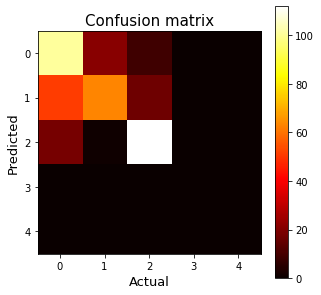


New checkpoint

train mode | time: 00:52:30
loss: 1.1445397185475639, accuracy: 0.7622471910112381, f1: 0.6847306937756371, precision: 0.7818789013732825, recall: 0.7949438202247192


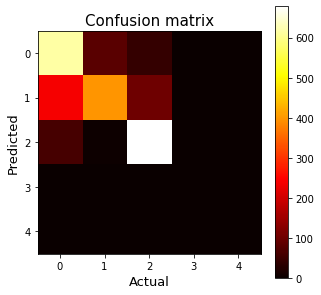

val mode | time: 00:52:37
loss: 1.2045404865191534, accuracy: 0.7230769230769227, f1: 0.6286426536426538, precision: 0.7462606837606837, recall: 0.7550925925925923


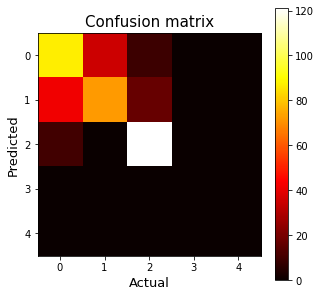

train mode | time: 00:52:37
loss: 1.1212790297658255, accuracy: 0.7878651685393291, f1: 0.7160576065632235, precision: 0.8032084893882642, recall: 0.8131647940074905


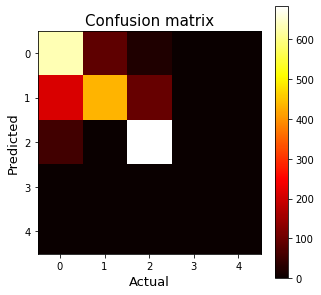

val mode | time: 00:52:44
loss: 1.1708707840014727, accuracy: 0.7564102564102558, f1: 0.6728530728530729, precision: 0.7795584045584044, recall: 0.7988247863247862


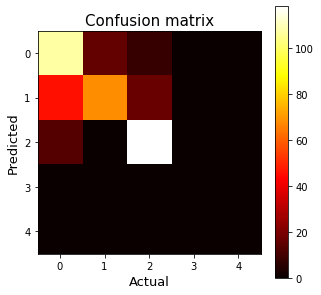


New checkpoint



In [31]:
trainer = Trainer(df=new_df, net=model, lr=1e-3, batch_size=5, num_epochs=4)
trainer.run(net=model)

In [132]:
train_logs = []
val_logs = []

train_logs = trainer.train_df_logs
train_logs.columns = ['train_' + colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ['val_' + colname for colname in val_logs.columns]

logs = pd.concat([train_logs, val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
]
logs.head()

,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1,train_precision,val_precision,train_recall,val_recall
0,0.965555,0.996048,0.944270,0.933333,0.924551,0.903022,0.947516,0.933939,0.947553,0.943376
1,0.965921,0.991194,0.945169,0.941026,0.918620,0.919017,0.947591,0.944444,0.947266,0.954060
2,0.954483,0.995055,0.955955,0.935897,0.935073,0.900020,0.958645,0.939815,0.959507,0.941239
3,0.952852,1.001750,0.956404,0.923077,0.939076,0.889947,0.960605,0.928063,0.959738,0.934829
4,0.950336,0.990391,0.960449,0.938462,0.943364,0.912281,0.964164,0.939103,0.962859,0.953704


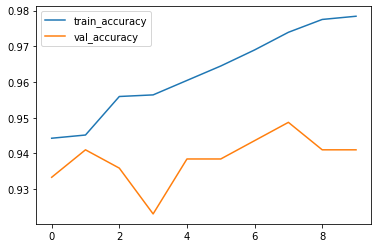

In [133]:
plt.plot(logs['train_accuracy'], label='train_accuracy')
plt.plot(logs['val_accuracy'], label='val_accuracy' )
plt.legend()
plt.show()

In [123]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():
            device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
            data = data.to(device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    
    return predictions_cls, ground_truths_cls

In [124]:
test_dataset = ECGDataset(df_mitbih_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=0, shuffle=False)

In [125]:
df_mitbih_test['label'].value_counts()

Normal                               16398
Premature ventricular contraction     1937
Artial Premature                      1673
Name: label, dtype: int64

In [126]:
y_pred, y_true = make_test_stage(test_dataloader, model)
y_pred.shape, y_true.shape

((20008,), (20008,))

In [127]:
def print_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    fig, ax = plt.subplots() 

    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        xticklabels=df['label'].unique(),
        yticklabels=df['label'].unique(),
        cmap='Oranges'
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

<Figure size 576x432 with 0 Axes>

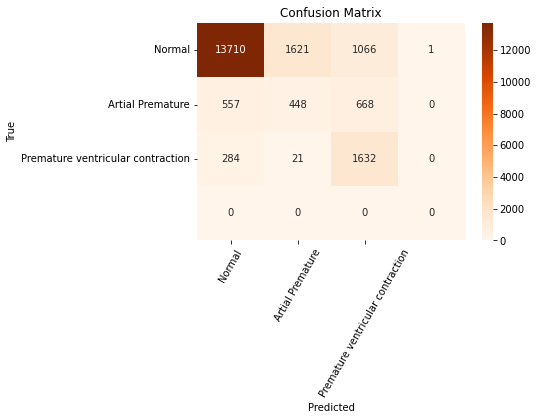

In [128]:
print_cm(y_true, y_pred)

In [129]:

print(f'Accuracy для тестовых данных: {accuracy_score(y_true, y_pred)}')

Accuracy для тестовых данных: 0.7891843262694922


## Пункт 4

In [135]:
new_df['class'].value_counts()

0    873
1    873
2    873
Name: class, dtype: int64

In [136]:
dfs = []
for i in range(5):
    dfs.append(new_df[new_df['class'] == i].tail(200))

new_short_df = pd.concat(dfs, axis=0)
new_short_df['class'].value_counts()

0    200
1    200
2    200
Name: class, dtype: int64

In [137]:

new_df_train = new_df.drop('label', axis=1)
automl = TabularAutoML(
    task=Task('multiclass'),
    timeout=300,
    reader_params={'cv': 3, 'random_state': 0},
    general_params={
        'use_algos': [['lgb', 'cb']],
        'default_algos': ['lgb', 'cb']
    },
    memory_limit=2,
    cpu_limit=1
)

predictions = automl.fit_predict(new_df_train, roles={'target': 'class'}, verbose=1).data

[23:04:33] Stdout logging level is INFO.
[23:04:33] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:04:33] Task: multiclass

[23:04:33] Start automl preset with listed constraints:
[23:04:33] - time: 300.00 seconds
[23:04:33] - CPU: 1 cores
[23:04:33] - memory: 2 GB

[23:04:33] Train data shape: (2619, 188)

[23:04:35] Layer 1 train process start. Time left 298.11 secs
[23:04:57] Selector_LightGBM fitting and predicting completed
[23:04:57] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[23:05:49] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.24803507003413522
[23:05:49] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[23:05:49] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[23:06:20] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.23097103039366784
[23:06:20] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[23:06:20] Time left 192.67 secs

[23:06:20] Layer 1 training completed.

[23:06:

In [138]:

new_df_test = new_df_test.dropna()
new_df_test = new_df_test.drop('label', axis=1)

test_predictions = automl.predict(new_df_test).data

In [139]:
predictions_classes = np.argmax(predictions, axis=1)
test_predictions_classes = np.argmax(test_predictions, axis=1)
train_classes = new_df_train['class']
test_classes = new_df_train['class']

In [140]:
(
    f'Accuracy train data: {accuracy_score(train_classes, predictions_classes)}',
    f'Accuracy test data: {accuracy_score(test_classes, test_predictions_classes)}'
)

('Accuracy train data: 0.9148529973272241',
 'Accuracy test data: 0.9996181748759069')

In [141]:
print(multilabel_confusion_matrix(test_classes, test_predictions_classes))

[[[1745    1]
  [   0  873]]

 [[1746    0]
  [   0  873]]

 [[1746    0]
  [   1  872]]]


<Figure size 576x432 with 0 Axes>

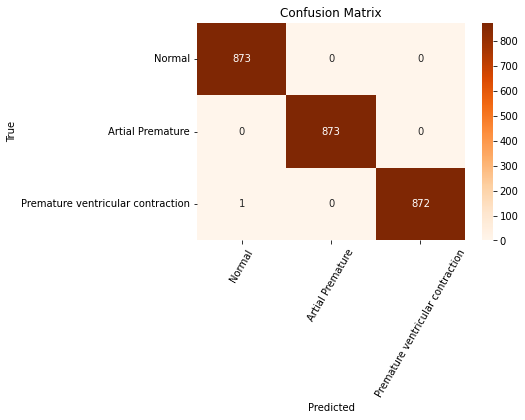

In [142]:
print_cm(test_classes, test_predictions_classes)

In [143]:
X_train = new_df_train.iloc[:, new_df_train.columns != 'class'].values
y_train = new_df_train.iloc[:, new_df_train.columns == 'class'].values.reshape(-1)

In [144]:
tpot = TPOTClassifier(generations=1, population_size=1, random_state=42, max_time_mins=5)
tpot.fit(X_train, y_train)

Version 0.12.1 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


TPOTClassifier(generations=1, max_time_mins=5, population_size=1,
               random_state=42)

In [145]:
X_test = new_df_test.iloc[:, new_df_test.columns != 'class'].values
y_test = new_df_test.iloc[:, new_df_test.columns == 'class'].values.reshape(-1)

In [146]:
y_train__predict = tpot.predict(X_train)
y_test__predict = tpot.predict(X_test)

In [147]:
(
    f'Accuracy train data: {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data: {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data: 0.6357388316151202',
 'Accuracy test data: 0.6357388316151202')

In [148]:

print(multilabel_confusion_matrix(y_test, y_test__predict))

[[[1534  212]
  [ 534  339]]

 [[1073  673]
  [ 194  679]]

 [[1677   69]
  [ 226  647]]]


<Figure size 576x432 with 0 Axes>

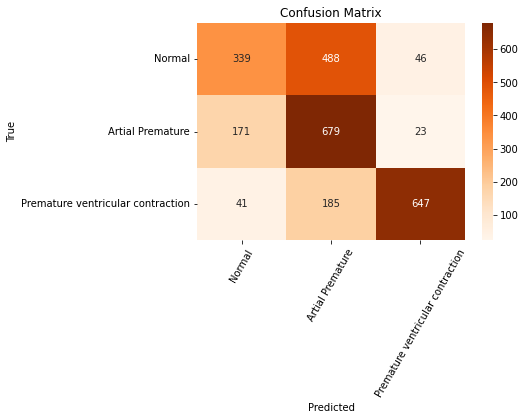

In [149]:
print_cm(y_test, y_test__predict)

In [150]:
fedot_model = Fedot(
    problem='classification',
    n_jobs=-1,
    timeout=3
)
fedot_model.fit(X_train, y_train)

2025-05-25 23:06:55,595 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2025-05-25 23:07:04,576 - ApiComposer - Initial pipeline was fitted in 8.9 sec.
2025-05-25 23:07:04,577 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 44.6 sec.
2025-05-25 23:07:04,578 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-05-25 23:07:04,585 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'dt', 'knn', 'logit', 'normalization', 'pca', 'qda', 'rf', 'scaling'].
2025-05-25 23:07:04,663 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 44.59257 sec.
2025-05-25 23:07:04,691 - ApiComposer - Hyperparameters tuning started with 3 min. timeout
2025-05-25 23:07:43,179 

{'depth': 3, 'length': 5, 'nodes': [logit, catboost, scaling, xgboost, lgbm]}

In [151]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [152]:
(
    f'Accuracy train data: {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data: {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data: 0.9851088201603666',
 'Accuracy test data: 0.9851088201603666')

In [153]:
print(multilabel_confusion_matrix(y_test, y_test__predict))

[[[1722   24]
  [  14  859]]

 [[1735   11]
  [  20  853]]

 [[1742    4]
  [   5  868]]]


<Figure size 576x432 with 0 Axes>

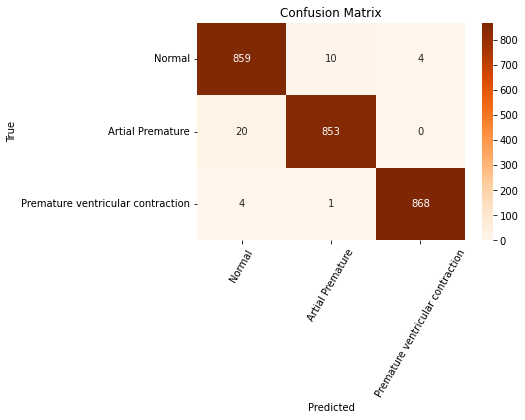

In [154]:

print_cm(y_test, y_test__predict)